![](https://www.gstatic.com/devrel-devsite/v2355ed73ae6b243a36832e70498f2cd0b3f352ff30481ebdfdc56826b566bf8a/tensorflow/images/lockup.svg)

До сегодняшнего дня мы собирали различные довольно простые модели в высокоуровневом API для [tensorflow](https://www.tensorflow.org/) под названием Keras. Сегодня, наконец, пришло время поиграться с голым ~~королём~~ функционалом библиотеки и посмотреть, как в нём собираются и обучаются самые простые модели. 

In [1]:
import numpy as np

In [2]:
import tensorflow as tf
tf.__version__  # ОУУУУ ЩИИИИТ, ВТОРАЯ ВЕРСИЯ!!! АААААААААААА

'2.0.0'

# 0. Tensoflow teaser

Давайте реализуем на `numpy` и на `tensorflow` функцию для поиска суммы квадратов первых $N$ чисел и посмотрим насколько быстро эти функции работают.

In [3]:
def np_sum_squares(N):
    return np.sum(np.arange(N)**2)

In [4]:
%%timeit
N = 10**8
np_sum_squares(N)

1.67 s ± 136 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Tensorflow из-за того, что мы сначала задаём структуру вычислений, а после осуществляем их, работает быстрее.

In [5]:
def tf_sum_squares(N):
    N = tf.constant(N, dtype='int64')
    return tf.reduce_sum((tf.range(N)**2))

In [6]:
%%timeit
N = 10**8
tf_sum_squares(N)

1.05 s ± 92.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Более того, когда вы уже задали свой граф вычислений и убедились, что всё работает, можно вызвать декоратор `tf.function`. [Он сделает работу заданного графа](https://www.tensorflow.org/tutorials/customization/performance) более оптимальной и ещё сильнее ускорит код. 

In [7]:
@tf.function
def tf_sum_squares(N):
    N = tf.constant(N, dtype='int64')
    return tf.reduce_sum((tf.range(N)**2))

In [8]:
%%timeit
N = 10**8
tf_sum_squares(N)

275 µs ± 36.5 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Если сравнивать время, то мы видим значительный прогресс в скорости вычислений даже для простой задачи. Данный прирост будет значительно большим для сложных и тяжелых по памяти рассчетов.

# 1. Тензоры и базовые операции над ними

Основной объект в tensorflow - это **тензор.** Или многомерный массив чисел. Чтобы не нужно было учить кучу новых команд, tensorflow косплеит numpy. 

```
    np.zeros -> tf.zeros
    np.sin -> tf.sin
    np.mean -> tf.reduce_mean
    np.arange -> tf.range
    np.cumsum -> tf.cumsum
```

Правда говоря, не совсем косплеит. Но чаще всего оказываетс довольно близок.

In [9]:
# можно задать тензор из нулей
tf.zeros([3, 4])

<tf.Tensor: id=105, shape=(3, 4), dtype=float32, numpy=
array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]], dtype=float32)>

In [10]:
# или из единиц, но уже более сложной размерности
tf.ones([3, 4, 2])

<tf.Tensor: id=108, shape=(3, 4, 2), dtype=float32, numpy=
array([[[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.]],

       [[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.]],

       [[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.]]], dtype=float32)>

In [11]:
# можно сгенерировать тензор из нормального распределения
tf.random.normal([2,2])

<tf.Tensor: id=114, shape=(2, 2), dtype=float32, numpy=
array([[-1.7302257 , -0.00920664],
       [-0.27910614,  1.0234534 ]], dtype=float32)>

In [12]:
# можно просто сделать залифку тензора какими-то числами
tf.fill([2, 2], 0.5)

<tf.Tensor: id=117, shape=(2, 2), dtype=float32, numpy=
array([[0.5, 0.5],
       [0.5, 0.5]], dtype=float32)>

In [13]:
# можно создать матрицу в numpy
x = np.array([[1, 2, 3, 4],
              [4, 3, 2, 1]])
x

array([[1, 2, 3, 4],
       [4, 3, 2, 1]])

In [14]:
# а потом перевести её в тензор
tf.convert_to_tensor(x, tf.float32) 

<tf.Tensor: id=118, shape=(2, 4), dtype=float32, numpy=
array([[1., 2., 3., 4.],
       [4., 3., 2., 1.]], dtype=float32)>

In [15]:
# или можно просто сразу создать тензор 
tf.constant([[1,  2,  3,  4],
             [5,  6,  7,  8],
             [9, 10, 11, 12]])

<tf.Tensor: id=119, shape=(3, 4), dtype=int32, numpy=
array([[ 1,  2,  3,  4],
       [ 5,  6,  7,  8],
       [ 9, 10, 11, 12]], dtype=int32)>

In [16]:
# наверное, стоит уточнить тип данных в тензоре
x = tf.constant([[1,  2,  3,  4],
                 [5,  6,  7,  8],
                 [9, 10, 11, 12]], dtype=tf.float32)

Все срезы, операции, размерности работают как в numpy.

In [17]:
x.dtype

tf.float32

In [18]:
x.shape

TensorShape([3, 4])

In [19]:
x[0]

<tf.Tensor: id=124, shape=(4,), dtype=float32, numpy=array([1., 2., 3., 4.], dtype=float32)>

In [20]:
x[:,1]

<tf.Tensor: id=128, shape=(3,), dtype=float32, numpy=array([ 2.,  6., 10.], dtype=float32)>

In [21]:
x + 10

<tf.Tensor: id=130, shape=(3, 4), dtype=float32, numpy=
array([[11., 12., 13., 14.],
       [15., 16., 17., 18.],
       [19., 20., 21., 22.]], dtype=float32)>

In [22]:
x[x > 3]

<tf.Tensor: id=159, shape=(9,), dtype=float32, numpy=array([ 4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.], dtype=float32)>

In [23]:
y = tf.constant([[12, 11, 10, 9],
                  [8, 7, 6, 5],
                  [4, 3, 2, 1]], dtype=tf.float32)

In [24]:
x + y

<tf.Tensor: id=161, shape=(3, 4), dtype=float32, numpy=
array([[13., 13., 13., 13.],
       [13., 13., 13., 13.],
       [13., 13., 13., 13.]], dtype=float32)>

In [25]:
x**y

<tf.Tensor: id=162, shape=(3, 4), dtype=float32, numpy=
array([[1.00000e+00, 2.04800e+03, 5.90490e+04, 2.62144e+05],
       [3.90625e+05, 2.79936e+05, 1.17649e+05, 3.27680e+04],
       [6.56100e+03, 1.00000e+03, 1.21000e+02, 1.20000e+01]],
      dtype=float32)>

In [26]:
tf.math.exp(x)

<tf.Tensor: id=163, shape=(3, 4), dtype=float32, numpy=
array([[2.7182817e+00, 7.3890562e+00, 2.0085537e+01, 5.4598152e+01],
       [1.4841316e+02, 4.0342880e+02, 1.0966332e+03, 2.9809580e+03],
       [8.1030840e+03, 2.2026465e+04, 5.9874141e+04, 1.6275480e+05]],
      dtype=float32)>

In [27]:
# Когда надоело работать с тензором, можно вернуться назад в numpy формат
x.numpy() 

array([[ 1.,  2.,  3.,  4.],
       [ 5.,  6.,  7.,  8.],
       [ 9., 10., 11., 12.]], dtype=float32)

In [28]:
# тип у тензоров может быть разный, но всегда один
tf.constant("hello world")

<tf.Tensor: id=164, shape=(), dtype=string, numpy=b'hello world'>

### Задание 1:

Попробуйте реализовать на tensorflow сигмоиду. 

$$ \sigma(x) = \frac{1}{1 + e^{-x}} $$

In [29]:
## Ответ: 
x = tf.linspace(-1.,1.,10)

sigma = 1 / (1 + tf.exp(-x))
sigma

<tf.Tensor: id=174, shape=(10,), dtype=float32, numpy=
array([0.26894143, 0.314799  , 0.36457646, 0.41742983, 0.4722508 ,
       0.52774924, 0.5825702 , 0.6354236 , 0.685201  , 0.7310586 ],
      dtype=float32)>

### Задание 2:

Попробуйте реализовать на tensorflow среднюю квадратичную ошибку. 

$$ 
MSE(\hat y, y) = \sum_{i=1}^n (\hat y - y)^2
$$

In [30]:
## Ответ: 
y_true = tf.constant([1,2,3,4,5])
y_predicted = tf.constant([5,4,3,2,1])

mse = tf.reduce_mean((y_true - y_predicted)**2)
mse

<tf.Tensor: id=181, shape=(), dtype=int32, numpy=8>

------------------------------------------

# 2. Производные да градиенты

Тензорфлоу может вычислять производные и градиенты автоматически. Для этого используется [`GradientTape.`](https://www.tensorflow.org/tutorials/customization/autodiff)

Он проходит по всем операциям, которые фигурируют в графе, и применяет к ним chain rule:

$$ {\partial f(g(x)) \over \partial x} = {\partial f(g(x)) \over \partial g(x)}\cdot {\partial g(x) \over \partial x} $$

Мы можем посчитать производную по любому тензору, участвующему в вычислениях.

In [31]:
x = tf.constant([0.3, 1])

# опция persistent=True позволяет искать производную много раз, а не один
with tf.GradientTape(persistent=True) as t:
    t.watch(x)
    y = tf.reduce_sum(x)
    z = y**2

In [32]:
t.gradient(z, x)

<tf.Tensor: id=196, shape=(2,), dtype=float32, numpy=array([2.6, 2.6], dtype=float32)>

In [33]:
t.gradient(z, y)

<tf.Tensor: id=202, shape=(), dtype=float32, numpy=2.6>

Нарисуем функцию и её производную на картинке :) 

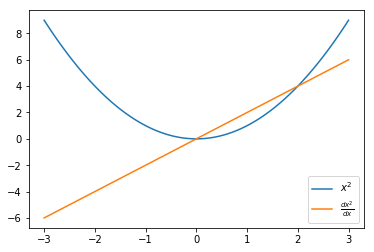

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

x = tf.linspace(-3., 3., 100)

with tf.GradientTape(persistent=True) as t:
    t.watch(x)
    y = x**2

dy_dx = t.gradient(y, x)

plt.plot(x, y, label="$x^2$")
plt.plot(x, dy_dx, label=r"$\frac{dx^2}{dx}$")
plt.legend();

### Задание 3:

Реализуйте расчёт градиента для функции 

$$
f(w) = \prod_{i,j} \ln(\ln(w_{ij} + 7) 
$$

в точке `w = [[5,10], [1,2]]`

In [35]:
# Ответ: 
w = tf.constant([[5,10], [1,2]], dtype=tf.float32)

with tf.GradientTape( ) as t:
    t.watch(w)
    f = tf.reduce_prod(tf.math.log(tf.math.log(w + 7)))

df_dw = t.gradient(f, w)
df_dw.numpy()

W1002 23:13:10.663706 140735755330496 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow_core/python/ops/math_grad.py:281: setdiff1d (from tensorflow.python.ops.array_ops) is deprecated and will be removed after 2018-11-30.
Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


array([[0.0201272 , 0.01089125],
       [0.04485611, 0.03509369]], dtype=float32)

# 3. Переменные

Следущий важный объект в tensorflow это **переменная.** Она представляет из себя некоторый буфер в памяти, который содержит текущие тензоры. 

* Переменную можно вставить в любое место графа 
* Переменные можно использовать, чтобы описать какую-то трансформацию
* В процессе расчётов их можно изменять
* Обычно их исползуют для описания параметров модели

In [36]:
w = tf.Variable(initial_value=0.5)
w

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.5>

In [37]:
x = np.array([1,2,3], dtype=float)
x

array([1., 2., 3.])

In [38]:
x*w

<tf.Tensor: id=396, shape=(3,), dtype=float32, numpy=array([0.5, 1. , 1.5], dtype=float32)>

Более того, переменные хороши тем, что Tensorflow сразу же следит за ними при вычислении производных. Ему не надо указывать с помощью команды `watch`, за каким тензором нужно приглядывать. 

### Задание 4:

Реализуйте расчёт градиента для функции 

$$
f(w) = \prod_{i,j} \ln(\ln(w_{ij} + 7) 
$$

в точке `w = [[5,10], [1,2]]`. Отличие от предыдущей задачки такое: надо задать $w$ не как тензор, а как переменную. 

In [39]:
# Ответ: 
w = tf.Variable(initial_value=[[5,10], [1,2]], dtype=tf.float32)

with tf.GradientTape( ) as t:
    f = tf.reduce_prod(tf.math.log(tf.math.log(w + 7)))

df_dw = t.gradient(f, w)
df_dw.numpy()

array([[0.0201272 , 0.01089125],
       [0.04485611, 0.03509369]], dtype=float32)

------------------------------------------

# 4. Оптимизация

Итак, tf умеет искать производные, осталось научиться применять его для оптимизации. 

Попробуем решить глупую задачку по конвертации градусов по цельсию в градусы по фаренгейту. По данным будем пытаться восстановить формулу: 

$$ f = c \times 1.8 + 32 $$

In [40]:
celsius    = np.array([-40, -10,  0,  8, 15, 22,  38],  dtype='float32')
fahrenheit = np.array([-40,  14, 32, 46, 59, 72, 100],  dtype='float32')

for i,c in enumerate(celsius):
    print("{} degrees Celsius = {} degrees Fahrenheit".format(c, fahrenheit[i]))

-40.0 degrees Celsius = -40.0 degrees Fahrenheit
-10.0 degrees Celsius = 14.0 degrees Fahrenheit
0.0 degrees Celsius = 32.0 degrees Fahrenheit
8.0 degrees Celsius = 46.0 degrees Fahrenheit
15.0 degrees Celsius = 59.0 degrees Fahrenheit
22.0 degrees Celsius = 72.0 degrees Fahrenheit
38.0 degrees Celsius = 100.0 degrees Fahrenheit


In [41]:
# параметры модели 
a = tf.Variable(tf.random.normal([1]), name='bias')
b = tf.Variable(tf.random.normal([1]), name='k')

a.numpy(), b.numpy()

(array([-0.35024723], dtype=float32), array([0.29618418], dtype=float32))

In [42]:
# Наша модель
def linear_regression(x):
    return a + b*x

# Ошибка для модели
def mean_square(y_pred, y_true):
    return tf.reduce_mean((y_pred-y_true)**2)

In [43]:
linear_regression(celsius).numpy()

array([-12.197615  ,  -3.312089  ,  -0.35024723,   2.0192263 ,
         4.0925155 ,   6.165805  ,  10.904752  ], dtype=float32)

In [44]:
mean_square(linear_regression(celsius), fahrenheit).numpy()

2762.9236

In [45]:
# оптимизатор 
optimizer = tf.optimizers.SGD(learning_rate=0.001)

# процесс оптимизации
def model_train(X, Y):

    # находим loss и пробрасываем градиент
    with tf.GradientTape() as g:
        pred = linear_regression(X)
        loss = mean_square(pred, Y)

    # Вычисляем градиенты
    gradients = g.gradient(loss, [a, b])
    
    # Обновляем веса a и b в ходе одной итерации спуска 
    optimizer.apply_gradients(zip(gradients, [a, b]))
    pass

In [46]:
# Обучение
epochs = 2000 # число эпох 

for i in range(epochs):
    
    # Делаем щаг градиентного спуска 
    model_train(celsius, fahrenheit)
    
    # Каждую сотую итерацию следим за тем, что произошло
    if i%100 == 0:
        y_pred = linear_regression(celsius)
        loss_val = mean_square(y_pred, fahrenheit)
        print("step: %i, loss: %f, a: %f, b: %f" % (i, loss_val, a.numpy(), b.numpy()))

step: 0, loss: 1022.360413, a: -0.271482, b: 2.281443
step: 100, loss: 679.016174, a: 5.362409, b: 2.022351
step: 200, loss: 462.308929, a: 10.012512, b: 1.983107
step: 300, loss: 314.769989, a: 13.849401, b: 1.950727
step: 400, loss: 214.322342, a: 17.015293, b: 1.924009
step: 500, loss: 145.935501, a: 19.627523, b: 1.901963
step: 600, loss: 99.376137, a: 21.782932, b: 1.883773
step: 700, loss: 67.677536, a: 23.561401, b: 1.868764
step: 800, loss: 46.096516, a: 25.028843, b: 1.856380
step: 900, loss: 31.403570, a: 26.239666, b: 1.846162
step: 1000, loss: 21.400347, a: 27.238737, b: 1.837730
step: 1100, loss: 14.589875, a: 28.063097, b: 1.830773
step: 1200, loss: 9.953258, a: 28.743279, b: 1.825033
step: 1300, loss: 6.796551, a: 29.304508, b: 1.820297
step: 1400, loss: 4.647361, a: 29.767595, b: 1.816388
step: 1500, loss: 3.184126, a: 30.149704, b: 1.813164
step: 1600, loss: 2.187945, a: 30.464983, b: 1.810503
step: 1700, loss: 1.509721, a: 30.725126, b: 1.808307
step: 1800, loss: 1.04

Можно сделать то же самое, но с визуализацией. 

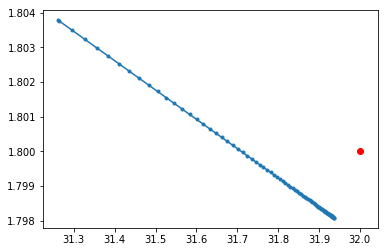

In [47]:
from IPython.display import clear_output

epochs = 2000 # число эпох 

ass = [a.numpy()[0]] # стартовые точки 
bss = [b.numpy()[0]] 

for i in range(epochs):
    # Делаем щаг градиентного спуска 
    model_train(celsius, fahrenheit)
    
    if i%25 == 0:
        # Пополняем запас точек 
        ass.append(a.numpy()[0])
        bss.append(b.numpy()[0])

        clear_output(True) # чтобы всё на одной картинке рисовалось, а не на милионе
        plt.plot(ass, bss, marker='.')
        plt.scatter(32, 1.8, c='red')
        plt.show()

### Задание 5:

Реализуйте для функции 

$$
f(w) = \prod_{i,j} \ln(\ln(w_{ij} + 7) 
$$

процедуру градиентного спуска. Каким получилось минимальное значение? 

In [48]:
#Ответ:
w = tf.Variable(initial_value=tf.random.normal([2,2]))

# добавили, чтобы проиллюстрировать комент про матричное диффириенцирование
#v = tf.Variable(initial_value=tf.random.normal([2,2])) 

# оптимизатор 
optimizer = tf.optimizers.SGD(learning_rate=0.001)

def find_min():
    # градиент 
    with tf.GradientTape( ) as t:
        f = tf.reduce_prod(tf.math.log(tf.math.log(w + 7)))# + v)
        
    # Вычисляем градиенты
    gradients = t.gradient(f, [w])#, v]) # СПИСОК МАТРИЦ, у нас тут матричное диффириенцирование
    
    print(gradients, '\n') # на них даже можно посмотреть :) 
    optimizer.apply_gradients(zip(gradients, [w]))#, v]))
    pass

find_min()

[<tf.Tensor: id=165015, shape=(2, 2), dtype=float32, numpy=
array([[0.01817186, 0.02705098],
       [0.01554612, 0.02445397]], dtype=float32)>] 



In [49]:
w = tf.Variable(initial_value=[[5., 10.], [1., 2.]])

# оптимизатор 
optimizer = tf.optimizers.SGD(learning_rate=1e-3)

def find_min():
    # градиент 
    with tf.GradientTape( ) as t:
        f = tf.reduce_prod(tf.math.log(tf.math.log(w + 7)))
        
    # Вычисляем градиенты
    gradients = t.gradient(f, [w]) # СПИСОК МАТРИЦ, у нас тут матричное диффириенцирование
    
    optimizer.apply_gradients(zip(gradients, [w]))
    pass


for i in range(500):
    find_min()
    if i % 100 == 0:
        print(w.numpy(), '\n')

[[4.99998   9.9999895]
 [0.9999551 1.999965 ]] 

[[4.9979773 9.99894  ]
 [0.9954669 1.9964602]] 

[[4.9959745  9.997891  ]
 [0.99097866 1.9929554 ]] 

[[4.993972   9.996842  ]
 [0.98648703 1.9894507 ]] 

[[4.991969   9.995793  ]
 [0.98199284 1.9859426 ]] 



------------------------------------------

Можно попробовать поразвлекаться с разными методами оптимизации! 

* На вход модели при обучении мы сейчас подавали нумпаевские вектора. В будущем мы будем смотреть и на разные другие способы скармливать модели данные.

# 5. Нейронка на Tensorflow 

Пришло время страдать. Чтобы пострадать как следует, вы получаете задание --- построить свою первую нейросеть в tensorflow. __Спойлер:__ cильнее вего вы будете страдать от того, что размерности матриц не сходятся. Осторожнее с этим. 

Раньше все учили свою первую нейросеть на [наборе рукопистных цифр MNIST.](http://yann.lecun.com/exdb/mnist/) Теперь это не модно. Если где-то кто-то будет проводить у вас семинар с участием этого датасета, так и скажите ему: __это не модно!__  Хлопать дверью или нет --- на ваше усмотрение. 

На арене туториалов новый король: [Fashion MNIST.](https://www.tensorflow.org/tutorials/keras/classification) По ссылке лежит туториал с строительством нейросетки на этом наборе, но с участием Keras. Мы пока что обойдёмся без него.

In [50]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [51]:
X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

In [52]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Нарисуем несколько рандомных картинок из тренировочной выборки. 

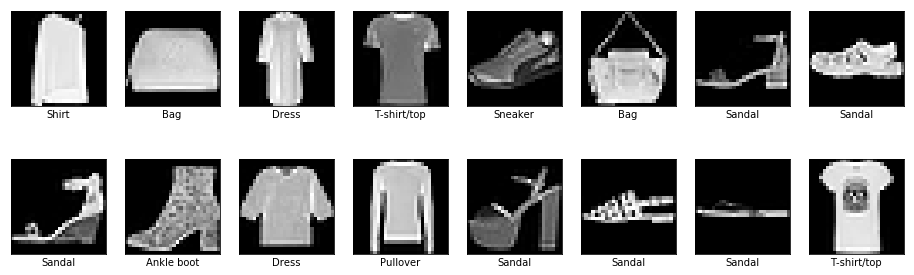

In [53]:
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols, 2.5 * rows))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(X_train[random_index, :], cmap = 'gray')
        ax.set_xlabel(class_names[y_train[random_index]])
plt.show()

Каждая картинка это матрица из чисел. Если число большое - пиксель яркий. Если маленькое - тёмный. Яркость измеряется по шкале от $0$ до $255$.

In [54]:
X_train

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

Картинка - матрица. 

In [55]:
X_train[0].shape

(28, 28)

Давайте отнормируем выборку. 

In [56]:
X_train = X_train/255
X_test = X_test/255

Будем прогнозировать тип картинки по её пикселям. Давайте растянем её в вектор из $28 \times 28$ фичей.

In [57]:
X_train = X_train.reshape(X_train.shape[0], 28**2)
X_test = X_test.reshape(X_test.shape[0], 28**2)
X_train.shape

(60000, 784)

Поставим для данных тип, чтобы ничего не поломалось.

In [58]:
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

У нас в задаче фигурирует $10$ классов. Последним слоем в сетке будет Softmax. Не забудьте сделать OHE, когда будете описывать функцию потерь. 

In [59]:
tf.keras.utils.to_categorical(y_train)

array([[0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [60]:
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

## Задание 6

Для начала обучим однослойною модель. Задайте её архитектуру и напишите функцию для прогнозирования. 

In [103]:
num_classes = 10   # число классов
num_features = 784 # число фичей (28*28 пикселей)

# создаем переменные, которые мы будем обновлять на каждой итерации в ходе обучения
# размерность [784, 10]
W = tf.Variable(tf.random.normal([num_features, num_classes]), name="weight", dtype=tf.float32)
# размерность [10]
b = tf.Variable(tf.zeros([num_classes]), name="bias", dtype=tf.float32)

# прогнозы
def logistic_regression(X):
    return tf.nn.softmax(tf.matmul(X, W) + b)

In [104]:
p_pred = logistic_regression(X_train[:5])
p_pred

<tf.Tensor: id=194093, shape=(5, 10), dtype=float32, numpy=
array([[2.3849236e-12, 6.4996094e-12, 6.0835711e-11, 2.4332267e-10,
        1.5223154e-16, 5.8584930e-05, 1.7466691e-08, 9.9992204e-01,
        1.3332098e-13, 1.9458272e-05],
       [1.6065937e-13, 7.1172544e-04, 2.4218212e-29, 1.0618717e-16,
        9.1029425e-21, 5.0069687e-10, 5.3412305e-07, 3.1327036e-01,
        1.0693272e-15, 6.8601739e-01],
       [1.0043894e-05, 9.3158901e-01, 8.9520572e-11, 1.6793324e-08,
        1.6859548e-10, 8.9906962e-07, 2.0607613e-05, 6.6641502e-02,
        6.3648127e-05, 1.6742898e-03],
       [1.4527210e-08, 9.5404166e-01, 3.2278259e-15, 3.7043602e-10,
        8.6356530e-12, 7.2706044e-08, 1.1262066e-06, 4.5791987e-02,
        7.4415587e-12, 1.6515421e-04],
       [3.6717076e-08, 1.4955360e-02, 8.2530878e-16, 1.7460986e-12,
        5.3996545e-14, 3.7775811e-12, 1.1396674e-05, 9.7494745e-01,
        1.4354794e-09, 1.0085794e-02]], dtype=float32)>

Отлично! Теперь давайте реализуем функцию потерь. Использовать будем logloss. Ещё не забыли как его искать? 

In [105]:
p_pred[0].numpy()

array([2.3849236e-12, 6.4996094e-12, 6.0835711e-11, 2.4332267e-10,
       1.5223154e-16, 5.8584930e-05, 1.7466691e-08, 9.9992204e-01,
       1.3332098e-13, 1.9458272e-05], dtype=float32)

In [106]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

In [107]:
y_train[0]*tf.math.log(p_pred[0])

<tf.Tensor: id=194104, shape=(10,), dtype=float32, numpy=
array([ -0.      ,  -0.      ,  -0.      ,  -0.      ,  -0.      ,
        -0.      ,  -0.      ,  -0.      ,  -0.      , -10.847239],
      dtype=float32)>

In [108]:
y_train[:5] * tf.math.log(p_pred)

<tf.Tensor: id=194107, shape=(5, 10), dtype=float32, numpy=
array([[ -0.      ,  -0.      ,  -0.      ,  -0.      ,  -0.      ,
         -0.      ,  -0.      ,  -0.      ,  -0.      , -10.847239],
       [-29.45949 ,  -0.      ,  -0.      ,  -0.      ,  -0.      ,
         -0.      ,  -0.      ,  -0.      ,  -0.      ,  -0.      ],
       [-11.508546,  -0.      ,  -0.      ,  -0.      ,  -0.      ,
         -0.      ,  -0.      ,  -0.      ,  -0.      ,  -0.      ],
       [ -0.      ,  -0.      ,  -0.      , -21.716341,  -0.      ,
         -0.      ,  -0.      ,  -0.      ,  -0.      ,  -0.      ],
       [-17.120024,  -0.      ,  -0.      ,  -0.      ,  -0.      ,
         -0.      ,  -0.      ,  -0.      ,  -0.      ,  -0.      ]],
      dtype=float32)>

In [109]:
tf.reduce_sum(y_train[:5] * tf.math.log(p_pred), axis=1)

<tf.Tensor: id=194112, shape=(5,), dtype=float32, numpy=
array([-10.847239, -29.45949 , -11.508546, -21.716341, -17.120024],
      dtype=float32)>

In [110]:
tf.reduce_sum(y_train[:5] * tf.math.log(p_pred), axis=1)

<tf.Tensor: id=194117, shape=(5,), dtype=float32, numpy=
array([-10.847239, -29.45949 , -11.508546, -21.716341, -17.120024],
      dtype=float32)>

In [111]:
tf.reduce_mean(-tf.reduce_sum(y_train[:5] * tf.math.log(p_pred), axis=1)) 

<tf.Tensor: id=194125, shape=(), dtype=float32, numpy=18.13033>

In [112]:
def logloss(p_pred, y_true):
    # Чтобы не возникло log(0) и бесконечностей
    p_pred = tf.clip_by_value(p_pred, 1e-9, 1.)
    # а теперь считаем
    return -tf.reduce_mean(tf.reduce_sum(y_true * tf.math.log(p_pred), axis=1)) 

In [113]:
p_pred = logistic_regression(X_train[:5])
logloss(p_pred, y_train[:5])

<tf.Tensor: id=194143, shape=(), dtype=float32, numpy=16.184467>

Чтобы избежать проблем с бесконечностями, обычно `logloss` считают по-другому, с помощью функции `tf.nn.softmax_cross_entropy_with_logits`. Откуда берутся проблемы в виде бесконечностей в softmax либо посмотрите во второй лекции, либо в Николенко на страницах $133-135.$

На каждой итерации будем искать accuracy. Напишите функцию, чтобы его искать. 

In [114]:
def accuracy(y_pred, y_true):
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_true,1))
    correct_prediction = tf.cast(correct_prediction, tf.float32)
    return tf.reduce_mean(correct_prediction)

In [115]:
accuracy(p_pred, y_train[:5])

<tf.Tensor: id=194152, shape=(), dtype=float32, numpy=0.0>

Задаём оптимизатор

In [116]:
learning_rate = 1e-4
optimizer = tf.optimizers.Adam(learning_rate)

Задаём один шаг обучения

In [117]:
def model_train(X, Y):

    # находим loss и пробрасываем градиент
    with tf.GradientTape() as g:
        pred = logistic_regression(X)
        loss = logloss(pred, Y)

    # Вычисляем градиенты
    gradients = g.gradient(loss, [W, b])
    
    # Обновляем веса a и b в ходе одной итерации спуска 
    optimizer.apply_gradients(zip(gradients, [W, b]))
    pass

In [118]:
W

<tf.Variable 'weight:0' shape=(784, 10) dtype=float32, numpy=
array([[ 1.4119296 ,  0.8086965 , -0.9121346 , ..., -0.19233146,
        -0.6168054 ,  0.18513358],
       [ 0.9259034 ,  0.6953167 , -0.8131353 , ...,  0.08105092,
         1.2810011 , -1.0041631 ],
       [-0.54130924,  0.15056646, -1.1403023 , ..., -0.7913274 ,
         0.07173686,  0.13921809],
       ...,
       [ 2.0747986 , -0.28531694, -1.2599752 , ...,  1.051404  ,
        -0.03530618,  2.124613  ],
       [ 0.56790555,  0.3707206 ,  0.7607965 , ..., -1.880468  ,
        -0.6797259 , -0.57807124],
       [-0.58078605, -0.10713533,  0.4094979 , ...,  2.234214  ,
        -0.4308102 ,  2.3629417 ]], dtype=float32)>

In [119]:
# Работает ли?
model_train(X_train, y_train)

In [120]:
W

<tf.Variable 'weight:0' shape=(784, 10) dtype=float32, numpy=
array([[ 1.4119296 ,  0.8086954 , -0.9121346 , ..., -0.19235751,
        -0.6168054 ,  0.18513358],
       [ 0.9259557 ,  0.6952836 , -0.8131353 , ...,  0.08098841,
         1.2810094 , -1.0041324 ],
       [-0.54122204,  0.15048592, -1.1402965 , ..., -0.791415  ,
         0.07174443,  0.1391833 ],
       ...,
       [ 2.0747013 , -0.2854158 , -1.2598817 , ...,  1.0513041 ,
        -0.03529838,  2.124713  ],
       [ 0.5678093 ,  0.37062636,  0.7607422 , ..., -1.8805678 ,
        -0.6797644 , -0.57797164],
       [-0.5808638 , -0.10719592,  0.4095466 , ...,  2.2341182 ,
        -0.43080965,  2.3630362 ]], dtype=float32)>

Остался только этап для обучения модели. Напишем функцию, которая будет генерировать из наших данных батчи. Одна эпоха - один проход модели по всем батчам. Один батч - совокупность наблюдений.  В этом может помочь [специальный класс для создания батчей, Dataset.](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)

In [121]:
# создали объект с данными для обучения 
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))

# перемешали данные с окном в 5000 и сделали кучу батчей размера 512 
train_data = train_data.shuffle(5000).batch(512)

Напишем небольшую функцию для визуализации процедуры обучения. 

In [122]:
from IPython import display

def visualize(l1,l2, h1, h2):
    plt.figure(figsize=(20,5)) 
    epo_range = range(1,len(h1)+1)
    tick_range = range(1,len(h1)+1,2)
    plt.subplot(1,2,1)
    plt.title('Learning loss')
    plt.plot(epo_range,l1, label='train set')
    plt.plot(epo_range,l2, label='valid set')
    plt.grid()
    plt.xticks(tick_range)
    plt.legend(title = 'Loss at:')
    
    plt.subplot(1,2,2)
    plt.title('Learning accuracy')
    plt.plot(epo_range,h1, label='train set')
    plt.plot(epo_range,h2, label='valid set')
    plt.grid()
    plt.xticks(tick_range)
    plt.ylim(0, 1.)
    plt.legend(title = 'Accuracy at:')
    
    display.clear_output(wait=True)
    plt.show()

Обучаем модель! 

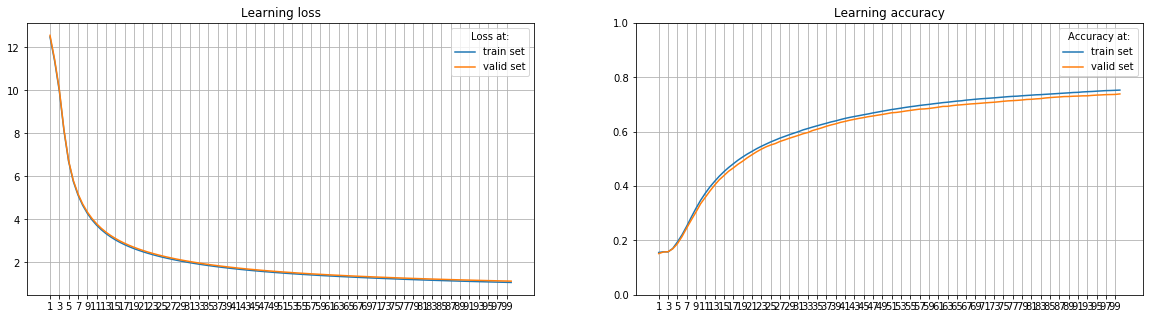

In [123]:
epochs = 100           # число эпох 
training_steps = 1000  # сколько раз на эпохе теребить генератор батчей

# Вектора для метрик
loss_test, loss_train  = [ ], [ ] 
acc_test, acc_train = [ ], [ ]

for i in range(epochs):
    
    # Проходимся по всем батчам
    for batch_x, batch_y in train_data.take(training_steps):
        
        # Делаем щаг градиентного спуска 
        model_train(batch_x, batch_y)
    
    p_train = logistic_regression(X_train)
    p_test = logistic_regression(X_test)
    
    loss_train.append(logloss(p_train, y_train))
    loss_test.append(logloss(p_test, y_test))
    
    acc_train.append(accuracy(p_train, y_train))
    acc_test.append(accuracy(p_test, y_test))
    
    # визуализируем
    visualize(loss_train, loss_test, acc_train, acc_test) 

Делать такие визуализации для больших нейронок и большого количества эпох не лучшая идея, но так как мы только учимся и хотим красивых картинок, то мы можем себе это позволить. __Отдельно обратите внимание,__ что TensorFlow очень чуствительна к размерностям. Например, чтобы работала функция `matmul`, нужно подать ей на вход обязательно матрицы. Даже если это матрица размера $1 \times 1$.

## Задание 7

Переделайте свою логистическую регрессию в двухслойную нейросетку. В качестве функции активации возьмите что угодно. 

In [124]:
num_classes = 10   # число классов
num_features = 784 # число фичей (28*28 пикселей)
hidden_neurons = 32

# создаем переменные, которые мы будем обновлять на каждой итерации в ходе обучения
#[784, 32]
W1 = tf.Variable(tf.random.normal([num_features, hidden_neurons]), name="weight", dtype=tf.float32)
#[32]
b1 = tf.Variable(tf.zeros([hidden_neurons]), name="bias", dtype=tf.float32)

# [32, 10]
W2 = tf.Variable(tf.random.normal([hidden_neurons, num_classes]), name="weight", dtype=tf.float32)
# [10]
b2 = tf.Variable(tf.zeros([num_classes]), name="bias", dtype=tf.float32)

# модель
def our_nn(X):
    h = tf.nn.sigmoid(tf.matmul(X, W1) + b1)
    h = tf.nn.softmax(tf.matmul(h, W2) + b2)
    return h

# функция потерь
def logloss(p_pred, y_true):
    return -tf.reduce_mean(tf.reduce_sum(y_true * tf.math.log(p_pred), axis=1)) 

# точность
def accuracy(y_pred, y_true):
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_true,1))
    correct_prediction = tf.cast(correct_prediction, tf.float32)
    return tf.reduce_mean(correct_prediction)

# Оптимизатор
learning_rate = 1e-4
optimizer = tf.optimizers.Adam(learning_rate)

# Шаг обучения
def model_train(X, Y):
    # находим loss и пробрасываем градиент
    with tf.GradientTape() as g:
        pred = our_nn(X)
        loss = logloss(pred, Y)

    # Вычисляем градиенты
    gradients = g.gradient(loss, [W1, b1, W2, b2])
    
    # Обновляем веса a и b в ходе одной итерации спуска 
    optimizer.apply_gradients(zip(gradients, [W1, b1, W2, b2]))
    pass

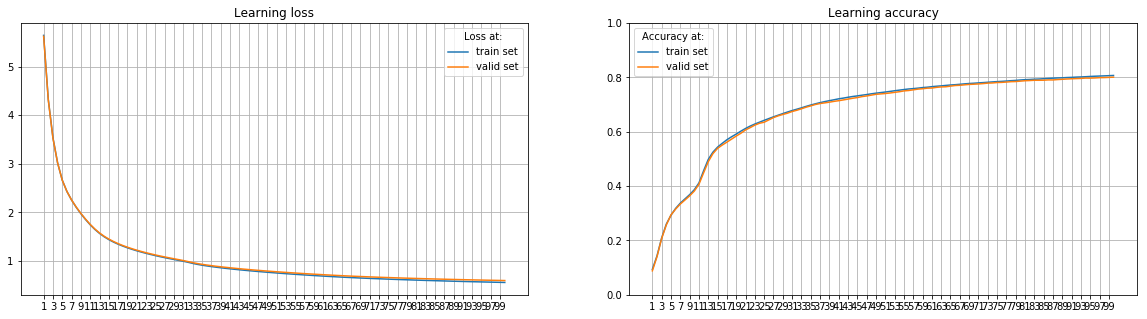

In [125]:
epochs = 100           # число эпох 
training_steps = 1000  # сколько раз на эпохе теребить генератор батчей

# Вектора для метрик
loss_test, loss_train  = [ ], [ ] 
acc_test, acc_train = [ ], [ ]

for i in range(epochs):
    
    # Проходимся по всем батчам
    for batch_x, batch_y in train_data.take(training_steps):
        
        # Делаем щаг градиентного спуска 
        model_train(batch_x, batch_y)
    
    p_train = our_nn(X_train)
    p_test = our_nn(X_test)
    
    loss_train.append(logloss(p_train, y_train))
    loss_test.append(logloss(p_test, y_test))
    
    acc_train.append(accuracy(p_train, y_train))
    acc_test.append(accuracy(p_test, y_test))
    
    # визуализируем
    visualize(loss_train, loss_test, acc_train, acc_test) 

# Вместо итога.

__Но... Но... Но... Намного проще собрать это в Keras! Зачем нам страдать?__

Дело в том, что Keras лишь надстройка над tensorflow. По факту все слои, написанные для Keras - это замаскированный tensorflow. Более того, даже сетку, написанную на Keras можно обучать таким вот незатейливым циклом, как у нас. Иногда так намного проще проверять свои идеи. 

* Например, в прошлый раз мы с вами пытались мень скорость обучения сетки с помощью колбэков прямо в процессе обучения. Это было довольно неприятно и код был неочевидным. Если описывать процедуру обучения в виде цикла, работать становится проще.  В Tensorflow проще делать довольно много разных вещей, а также проще реализовывать и проверять какие-то свои идеи. 
* В том числе на Tensorflow можно писать новые слои для Keras и встраивать их в свои сетки. Этим мы тоже с вами позанимаемся.

# N+1. Как Tensorflow работал раньше 

Больше такой код не надо писать никогда и нигде. Если видите его в туториалах в интернете, сразу закрывайте их. Эти туториалы устарели. Можете попробовать подуть на них (сдуть слой пыли), а дальше попробовать самостоятельно переписать старый код на новый. Это неплохое упражнение :) 

In [ ]:
import tensorflow.compat.v1 as tf  # подгружаем первую версию библиотеки 
tf.disable_v2_behavior()           # отключаем функционал второй 
                                   # теперь код, написанный на версии tf 1.x должен работать 
tf.__version__

Раньше сначала надо было задать структуру вычислений с помощью тензоров. 

In [ ]:
# что происходило в первой версии 
a = tf.constant([1, 2])
b = tf.constant([3, 4])

print(a + b)

Результат на лету было увидеть нельзя. 

In [ ]:
c = a + b
с

Если хотелось результата, надо было запускать вычислительную сессию, которая прогоняла все данные через граф.

In [ ]:
# открываем вычислительную сессию 
with tf.Session() as sess:
    print(sess.run(с))

In [ ]:
# либо можно было открыть глобальную сессию 
sess = tf.InteractiveSession()
c.eval()

Процедура обучения модели выглядела раньше иначе. Кроме переменных в обучении участие принимал ещё один объект, `placeholder`. 

* __placeholder__ — место в графе, которое может принимать входные параметры в граф извне. В эти места мы будем вставлять наши данные

In [ ]:
epochs = 10

# плейсхолдеры для данных 
# "Я обещаю вставить сюда x и y позже"
x = tf.placeholder(tf.float32)
y = tf.placeholder(tf.float32)

# параметры модели 
a = tf.Variable(tf.zeros([1]), name='bias')
b = tf.Variable(tf.zeros([1]), name='k')

# модель 
y_hat = b*x + a

# функция потерь и метод оптимизации
loss = tf.sqrt(tf.reduce_sum((y - y_hat)**2))
opt = tf.train.AdamOptimizer(learning_rate = 0.1)

# из-за того, что не было динамических вычислений, 
# было проще с градиентами
step = opt.minimize(loss)

# Но зато было сложнее с процедурой обучения, надо было запускать ... сессии
# открываем вычислительную сессию 
with tf.Session() as sess:
    
    # инициализировали все переменные 
    tf.global_variables_initializer().run() 
    
    for i in range(epochs):
        
        # Дорогая сессия, вычисли мне результат функции потерь, пожалуйста! Вот тебе конкретные x и y! 
        cur_loss = sess.run(loss, feed_dict={x:celsius, y:fahrenheit})
        print('Текущие потери:', cur_loss)
        
        # шаг оптимизации 
        sess.run(step, feed_dict={x:celsius, y:fahrenheit})
        
    print('\nКоэффициенты:', a.eval()[0], b.eval()[0])
    print('Прогнозы:', sess.run(y_hat, feed_dict={x:[-40,0,38]}))

## Почиташки

* [Эффективный tensorflow 2.0](https://www.tensorflow.org/guide/effective_tf2)
* [Простые примеры кода на tensorflow 2.0](https://github.com/aymericdamien/TensorFlow-Examples/tree/master/tensorflow_v2)
* [Очень-очень милая презентация про fashion mnist](https://github.com/fbchow/fashion-mnist-tensorflow/blob/master/ml-fashion-mnist-presentation.pdf)


__Немного старья:__

* [Введение в старую версию Tensorflow на Хабре](https://habrahabr.ru/company/ods/blog/324898/)
* [Введение в старый Tensorflow от ШАД,](https://nbviewer.jupyter.org/github/yandexdataschool/Practical_DL/blob/fall18/week02_autodiff/seminar_tensorflow.ipynb) моя тетрадка частично основана на этой тетрадке, хоть сходство на первый взгляд и не заметно. 
* [Неплохая подборка разных тетрадок](https://github.com/Hvass-Labs/TensorFlow-Tutorials) на старом tensorflow